In [ ]:
## Load the data

In [1]:
############## create sql table ################
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'stack_exchange_rnn_db'
q_tbname = 'question_table'
a_tbname = 'answer_table'
username = 'dan-laptop'
import os
password = os.environ['PGRES_PASSWORD']

engine = create_engine('postgresql://%s:%s@localhost:5432/%s'%(username,password,dbname))

## Now access sql db from python
con = None
connect_str = "dbname='%s' user='%s' host='localhost' password='%s'"%(dbname,username,password)
con = psycopg2.connect(connect_str)
cur = con.cursor() #create cursor for communicating with sql

In [2]:
import pandas as pd
################# make query ########################
sql_query = 'SELECT view_count,score FROM question_table;'
question_df = pd.read_sql_query(sql_query,con)
question_df.head()

,view_count,score
0,94,0
1,2859,0
2,8166,11
3,2936,-2
4,3748,4


In [3]:
#sql_query = 'SELECT * FROM question_table;'
#question_df = pd.read_sql_query(sql_query,con)
#question_df.to_csv('question_db.csv')

#sql_query = 'SELECT * FROM answer_table;'
#question_df = pd.read_sql_query(sql_query,con)
#question_df.to_csv('answer_db.csv')

In [4]:
import numpy as np
np.sum(question_df['view_count']<51)/len(question_df['view_count'])

0.20320205949987707

In [5]:
################# make query ########################
sql_query = 'SELECT word_vec,score FROM answer_table;'
question_df = pd.read_sql_query(sql_query,con)
print(question_df.shape)

(499225, 2)


In [6]:
################# make query ########################
sql_query = """
    SELECT answer_table.word_vec, answer_table.score 
    FROM answer_table
    INNER JOIN question_table
        on answer_table.q_id = question_table.q_id
        and question_table.view_count > 50
    LIMIT 10000
"""
question_df = pd.read_sql_query(sql_query,con)
print(question_df.shape)
question_df.head()

(10000, 2)


,word_vec,score
0,"the,error,object,may,read,from,the,network,net...",0
1,"this,is,what,i,did,worked,for,me,when,reading,...",0
2,"possible,duplicate,stackoverflow,com,questions...",0
3,"you,are,looking,for,idxmax,in,1332,x,out,1332,...",2
4,"x,max,x,max,x,max,axis,1,max,index,this,works,...",0


In [7]:
#question_df.to_csv('full_answers_50more_views.csv')

In [8]:
import numpy as np
threshold = 2

y = question_df['score'].copy()
y[y<threshold] = 0
y[y>0] = 1
print(np.mean(y))

0.2353


https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [9]:
gen = question_df.iterrows()

all_text = []
for rows in gen:
    all_text.extend(rows[1]['word_vec'].split(','))

In [10]:
from keras.preprocessing.text import Tokenizer

MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 40000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 30653 unique tokens.


In [11]:
from keras.preprocessing.sequence import pad_sequences

data = []
gen = question_df.iterrows()
for i,rows in enumerate(gen):
    tokens = tokenizer.texts_to_sequences(rows[1]['word_vec'].split(','))
    tokens = [x[0] for x in tokens]
    padded_seq = pad_sequences([tokens],maxlen=MAX_SEQUENCE_LENGTH)
    data.append(padded_seq)

# data, chapter_label = [],[]
# for chapter,sent in zip(ch_label,hold_data):
#     if np.shape(sent.T)[0] == 1:
#         hold = np.zeros((MAX_SEQUENCE_LENGTH,))
#         if len(sent) > MAX_SEQUENCE_LENGTH: sent = sent[:MAX_SEQUENCE_LENGTH]
#         hold[-len(sent):] = np.squeeze(sent)
#         data.append(np.array(hold))
#         hold = np.zeros((num_chapters,))
#         hold[chapter-1] = 1
#         chapter_label.append(hold)
#     else:
#         continue

# data = np.array(data)
# chapter_label = np.array(chapter_label)

# print('Shape of data tensor:', data.shape)
data = np.array(data)
data = np.squeeze(data)
data.shape

(10000, 500)

In [12]:
from keras.utils.np_utils import to_categorical

y = to_categorical(np.asarray(y))    

In [13]:
VALIDATION_SPLIT = 0.2

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
y = y[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = y[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = y[-nb_validation_samples:]

http://nlp.stanford.edu/data/glove.42B.300d.zip

In [14]:
import os

BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
#I would like to use one of the larger ones given the huge vocab of this book, but i don't have the ram

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt')) 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [89]:
#http://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
import math
def create_class_weight(y,mu=1.5):
    total,classes = y.shape
    class_weight = dict()

    for cats in range(classes):
        #score = total/float(sum(y[:,cats]==1))
        score = math.log(mu*total/float(sum(y[:,cats]==1)))
        class_weight[cats] = score if score > 1.0 else 1.0

    return class_weight

In [118]:
weight_dict = create_class_weight(y_train,mu=2.)
weight_dict

{0: 1.0, 1: 2.1434468716557484}

In [121]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, GRU, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.75)(embedded_sequences)
#x = GRU(4, dropout_W=0.2, dropout_U=0.2)(embedded_sequences)
x = Flatten()(x)
#x = Dense(32, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.75)(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# happy learning!
model.optimizer.lr = 0.0001
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=3, batch_size=32,class_weight=weight_dict)
#model.save_weights('./stackex_convnet.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/3
8000/8000 [==============================] - 26s - loss: 1.0240 - acc: 0.6594 - val_loss: 0.5844 - val_acc: 0.7565
Epoch 2/3
8000/8000 [==============================] - 23s - loss: 0.8255 - acc: 0.7233 - val_loss: 0.5706 - val_acc: 0.7470
Epoch 3/3
8000/8000 [==============================] - 26s - loss: 0.7641 - acc: 0.7478 - val_loss: 0.5516 - val_acc: 0.7505


In [ ]:
model.optimizer.lr = 0.01
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=5, batch_size=32,class_weight=weight_dict)

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 23s - loss: 0.7519 - acc: 0.7469 - val_loss: 0.5487 - val_acc: 0.7475
Epoch 2/5
8000/8000 [==============================] - 24s - loss: 0.7328 - acc: 0.7527 - val_loss: 0.5357 - val_acc: 0.7485
Epoch 3/5
2752/8000 [=========>....................] - ETA: 19s - loss: 0.7117 - acc: 0.7475

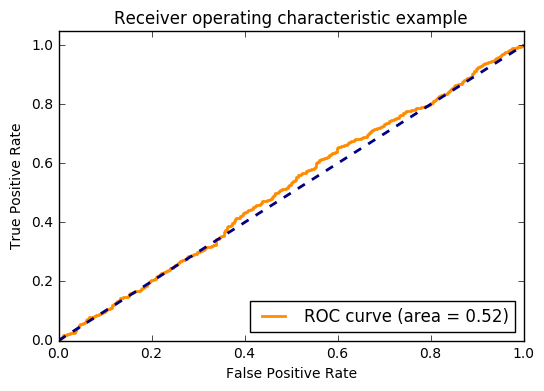

In [120]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#%matplotlib inline

def create_ROC_plt(lg,X_test,y_test,lw=2):
    y_score = lg.predict(X_test)[:,0]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',\
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
create_ROC_plt(model,x_val,y_val[:,0])
plt.show()

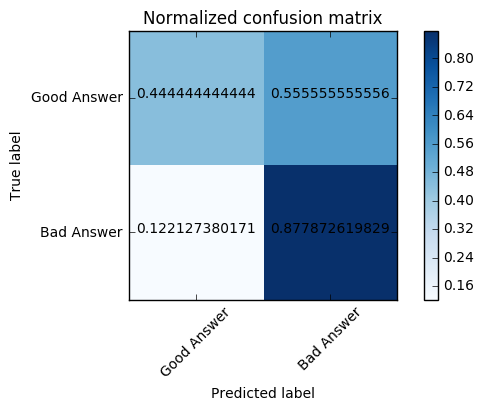

In [108]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 1.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(x_val)[:,0]
y_pred = [round(x) for x in y_pred]

from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val[:,0], y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Good Answer','Bad Answer'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

In [30]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=5, batch_size=32)

Train on 200 samples, validate on 40 samples
Epoch 1/5
200/200 [==============================] - 23s - loss: 0.5668 - acc: 0.7250 - val_loss: 0.4764 - val_acc: 0.8250
Epoch 2/5
200/200 [==============================] - 23s - loss: 0.5713 - acc: 0.7500 - val_loss: 0.4761 - val_acc: 0.8250
Epoch 3/5
200/200 [==============================] - 23s - loss: 0.5528 - acc: 0.7450 - val_loss: 0.4690 - val_acc: 0.8500
Epoch 4/5
200/200 [==============================] - 23s - loss: 0.5576 - acc: 0.7450 - val_loss: 0.4650 - val_acc: 0.8500
Epoch 5/5
200/200 [==============================] - 23s - loss: 0.5469 - acc: 0.7450 - val_loss: 0.4601 - val_acc: 0.8500
